In [1]:
%matplotlib inline
import sys
import os
import gym
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from collections import namedtuple
from itertools import count
from tqdm import tqdm

if '../' not in sys.path:
    sys.path.append('../')
from lib import plots
matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCarContinuous-v0")

//anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
# create features
observations = np.array([env.observation_space.sample() for i in tqdm(range(12000))])
scaler = StandardScaler()
scaler.fit(observations)
observations = scaler.transform(observations)

# Concatenate results of multiple features
featurizer = FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])
featurizer.fit(observations)


100%|██████████| 12000/12000 [00:00<00:00, 13330.95it/s]


FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [4]:
def featurize_state(state):
    state = scaler.transform([state])
    featurized = featurizer.transform(state)
    return featurized[0]

In [5]:
class PolicyEstimator():    
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist._sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [6]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plots.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in count():
            
            # env.render()
            
            # Take a step
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [8]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)
    for i_episode in range(20):
        print(i_episode)
        observation = env.reset()
        for t in count():
            env.render()
        
            action = policy_estimator.predict(observation, sess)
            observation, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
        env.close()

W0503 18:57:04.688073 4503598528 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0503 18:57:05.854552 4503598528 deprecation.py:323] From //anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1866: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0503 18:57:05.888031 4503598528 deprecation.py:323] From <ipython-input-5-7923831a1c84>:27: Normal.__init__ (from tensorflow.python.ops.distributions.normal) is deprecated and will be removed after 2019-01-01.
Instructions for updating:

Step 237 @ Episode 50/50 (81.04950324010146)0
Episode finished after 161 timesteps
1
Episode finished after 147 timesteps
2
Episode finished after 213 timesteps
3
Episode finished after 248 timesteps
4
Episode finished after 185 timesteps
5
Episode finished after 152 timesteps
6
Episode finished after 315 timesteps
7
Episode finished after 185 timesteps
8
Episode finished after 152 timesteps
9
Episode finished after 230 timesteps
10
Episode finished after 291 timesteps
11
Episode finished after 269 timesteps
12
Episode finished after 207 timesteps
13
Episode finished after 231 timesteps
14
Episode finished after 305 timesteps
15
Episode finished after 175 timesteps
16
Episode finished after 160 timesteps
17
Episode finished after 253 timesteps
18
Episode finished after 220 timesteps
19
Episode finished after 232 timesteps


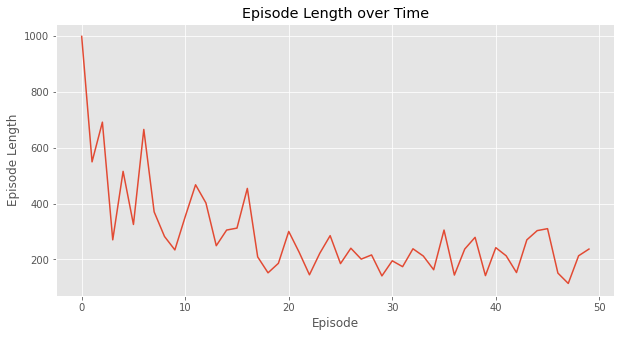

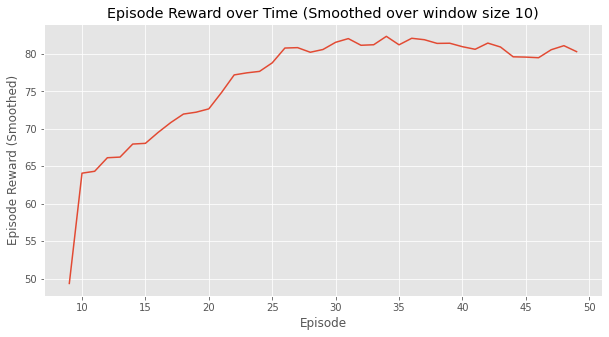

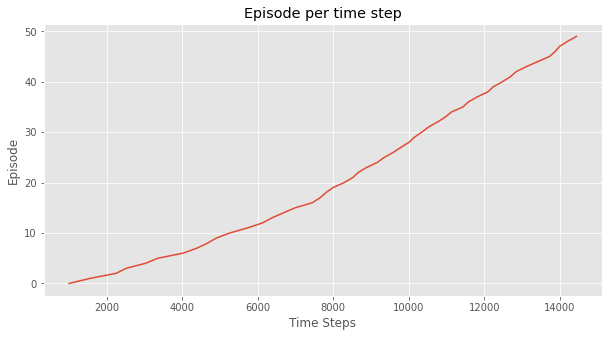

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plots.plot_episode_stats(stats, smoothing_window=10)

In [ ]:
env = gym.envs.make("MountainCarContinuous-v0")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i_episode in range(20):
        print(i_episode)
        observation = env.reset()
        for t in count():
            env.render()
        
            action = policy_estimator.predict(observation, sess)
            observation, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
        env.close()

//anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0
Episode finished after 999 timesteps
1
Episode finished after 999 timesteps
2
Episode finished after 999 timesteps
3
Episode finished after 999 timesteps
4
Episode finished after 999 timesteps
5
